#Load Data and Functions

In [0]:
import os  

if not os.path.isfile('./SongsProfiles.csv'):
  !unzip -qq augustoDiasPilotDataset.zip

In [0]:
# from google.colab import files
# !rm SessionsProfile.csv
# uploaded = files.upload()

In [10]:
from pandas import read_csv
from copy import copy
import numpy as np
from collections import Counter

sessionsProfile = read_csv('SessionsProfile.csv')
songsProfiles = read_csv('SongsProfiles.csv')

print(len(sessionsProfile))
sessionsProfile

# Expert = sessionsProfile['songName'].unique()

# # Create Expert index
# l = {}
# for i, speed in enumerate(Expert):
#     l[speed] = i
# print (l)
# Counter(sessionsProfile['Expert3'])

94


,id,songName,Expert1,Expert2,Expert3,Expert4,Expert5,Expert6
0,46,Agarradinho,no,NaN,NaN,NaN,no,no
1,47,Nosso Xote,no,no,NaN,NaN,NaN,no
2,48,Vida Boa Danada,no,no,no,NaN,NaN,NaN
3,59,Xote Triste,NaN,no,no,no,NaN,NaN
4,60,Nosso Xote,NaN,NaN,no,no,no,NaN
...,...,...,...,...,...,...,...,...
89,616,Xote Triste,yes,no,NaN,NaN,NaN,yes
90,617,Danielle,no,no,empty,NaN,NaN,NaN
91,618,Maria do Povo,NaN,no,empty,yes,NaN,NaN
92,619,Maria do Povo,NaN,NaN,empty,yes,yes,NaN


In [0]:
def calculateWaveScore(x, timestamp, l = 1, maxLoc = 150):
  from scipy.signal import find_peaks
  from scipy.signal import argrelextrema
  from scipy import signal  

  # Removing Gravity from the Data ----------------------------
  alpha = 0.9;
  gravity = 0;
  step2 = x.copy();
  for i in range(len(x)):
    gravity = alpha * gravity + (1 - alpha) * x[i];
    step2[i] = x[i] - gravity;
  # Removing Gravity from the Data ----------------------------

  b, a = signal.butter(3, 0.025, 'low')
  step3 = signal.filtfilt(b, a, step2)

  # Find wave peak and calculate Time Between Peaks (TBP)
  # peaks, _ = find_peaks(step3, distance=maxLoc)
  peaks = argrelextrema(step3, comparator=np.greater,order=150)[0]
  diffPeak = np.diff(timestamp[peaks], n = l)

  # Remove TBP outliers
  median = np.median(diffPeak)
  upper_quartile = np.percentile(diffPeak, 75)
  lower_quartile = np.percentile(diffPeak, 25)
  iqr = upper_quartile - lower_quartile
  upper_whisker = diffPeak[diffPeak<=upper_quartile+1.5*iqr].max()
  lower_whisker = diffPeak[diffPeak>=lower_quartile-1.5*iqr].min()
  diffPeakNoOutliers = diffPeak[(diffPeak > lower_whisker) & (diffPeak < upper_whisker)]

  # Calculate Scores
  score = (1 - np.std(diffPeakNoOutliers)/np.mean(diffPeakNoOutliers))*100
  cycleSize = np.mean(diffPeakNoOutliers)
  bpm = (60 / (cycleSize / 1000) ) * 8
  #print(score, cycleSize, bpm)
  return([score,bpm])

In [0]:
def getRiMoDeScore(id):
  from pandas import read_csv
  import array
  accData = read_csv( str(id) + '_acc.csv' )
  # Calculate best wave score - results differ from R implementation
  allScores = np.asarray([
    calculateWaveScore(accData['x'],accData['timestamp'],1,150),
    calculateWaveScore(accData['y'],accData['timestamp'],1,150),
    calculateWaveScore(accData['z'],accData['timestamp'],1,150),
    calculateWaveScore(-accData['x'],accData['timestamp'],1,150),
    calculateWaveScore(-accData['y'],accData['timestamp'],1,150),
    calculateWaveScore(-accData['z'],accData['timestamp'],1,150)
    ])
  consistencyScores = allScores[:,0]
  maxIndex = consistencyScores.argmax(axis=0)
  return allScores[maxIndex,:]  

#Plot Data

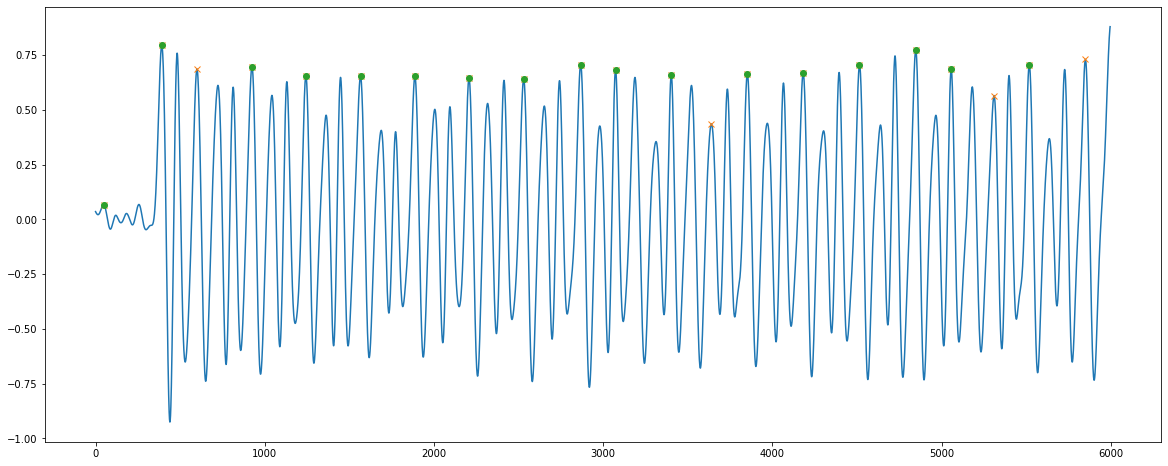

In [13]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import argrelextrema
from scipy import signal

plt.rcParams["figure.figsize"] = [20, 8]

accData = read_csv( '616' + '_acc.csv' )

x = -accData['z']

# Removing Gravity from the Data ----------------------------
alpha = 0.9;
gravity = 0;
step2 = x.copy();
for i in range(len(x)):
  gravity = alpha * gravity + (1 - alpha) * x[i];
  step2[i] = x[i] - gravity;
# Removing Gravity from the Data ----------------------------

b, a = signal.butter(3, 0.025, 'low')
step3 = signal.filtfilt(b, a, step2)
peaks, _ = find_peaks(step3, distance=150)
#peaks, _ = find_peaks(step3, distance=150, prominence=1)
peaks2 = argrelextrema(step3, comparator=np.greater,order=150)[0]

plt.plot(step3)
plt.plot(peaks, step3[peaks], "x")
plt.plot(peaks2, step3[peaks2], "o")
plt.show()

## Create dataset for machine learning classification task

In [14]:
import pandas as pd
import time
start = time.time()           # let's see how long this takes
df = pd.DataFrame(columns=['userBPM','userConsistency','songBPM','ratioBPM','ratioBPMabs','onRhythm'],dtype=float)

for i in range(len(sessionsProfile)):
#for i in range(10):
  noValues = sessionsProfile.iloc[i].values.tolist().count('no')
  yesValues = sessionsProfile.iloc[i].values.tolist().count('yes')
  expertVoting = 0 if noValues > yesValues  else 1
  # expertVoting = expertVoting if yesValues != noValues else 99
  consistency, bpm  = getRiMoDeScore(sessionsProfile.iloc[i,0])
  songName = sessionsProfile.iloc[i,1]
  songBPM = songsProfiles[songsProfiles['Song'].isin([songName])]['BPM'].values[0]
  ratioBPM = bpm/songBPM
  ratioBPMabs = abs(ratioBPM-1)
  df.loc[i] = list([bpm, consistency, songBPM, ratioBPM, ratioBPMabs, expertVoting])

finish = time.time()
print(f'time of execution: {finish-start}')
print(len(df))
df


time of execution: 72.67568349838257
94


,userBPM,userConsistency,songBPM,ratioBPM,ratioBPMabs,onRhythm
0,115.794552,96.791417,125.072886,0.925817,0.074183,0.0
1,122.156054,98.096265,143.072744,0.853804,0.146196,0.0
2,136.411333,95.401827,173.938766,0.784249,0.215751,0.0
3,179.472799,90.592746,145.745691,1.231411,0.231411,0.0
4,155.309649,79.355237,143.072744,1.085529,0.085529,0.0
...,...,...,...,...,...,...
89,146.004432,98.511059,145.745691,1.001775,0.001775,1.0
90,245.977247,97.762982,246.476037,0.997976,0.002024,0.0
91,219.435114,96.976575,219.711726,0.998741,0.001259,1.0
92,217.084785,97.568417,219.711726,0.988044,0.011956,1.0


## Check cases where there is no majority in votes

In [15]:
print(df[df['onRhythm'].isin([99])])
index99 = df[df['onRhythm'].isin([99])].index.values
sessionsProfile.iloc[index99]

Empty DataFrame
Columns: [userBPM, userConsistency, songBPM, ratioBPM, ratioBPMabs, onRhythm]
Index: []


,id,songName,Expert1,Expert2,Expert3,Expert4,Expert5,Expert6


## Test running time for parallel execution

In [17]:
import concurrent.futures
import time, random               # add some random sleep time

def procedure(j):                 # just factoring out the
    # parameter = j * offset        # procedure
    # call the calculation
    return getRiMoDeScore(sessionsProfile.iloc[j,0])

def main():
    output1 = list()
    start = time.time()           # let's see how long this takes

    # we can swap out ProcessPoolExecutor for ThreadPoolExecutor
    with concurrent.futures.ProcessPoolExecutor() as executor:
        for out1 in executor.map(procedure, range(0, 10)):
            # put results into correct output list
            output1.append(out1)
    finish = time.time()
    # these kinds of format strings are only available on Python 3.6:
    # time to upgrade!
    print(f'original inputs: {repr(output1)}')
    print(f'time saved by parallelizing: {finish-start}')

if __name__ == '__main__':
    main()

original inputs: [array([ 96.79141727, 115.79455239]), array([ 98.0962654 , 122.15605436]), array([ 95.40182708, 136.41133263]), array([ 90.59274634, 179.47279865]), array([ 79.3552368 , 155.30964861]), array([ 71.30079277, 124.9078371 ]), array([ 80.50722955, 180.31555222]), array([ 98.81077758, 125.18582271]), array([ 99.89869131, 143.78791283]), array([ 98.15109467, 145.71268448])]
time saved by parallelizing: 7.191216230392456


## Run machine learning classification algorithms
https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

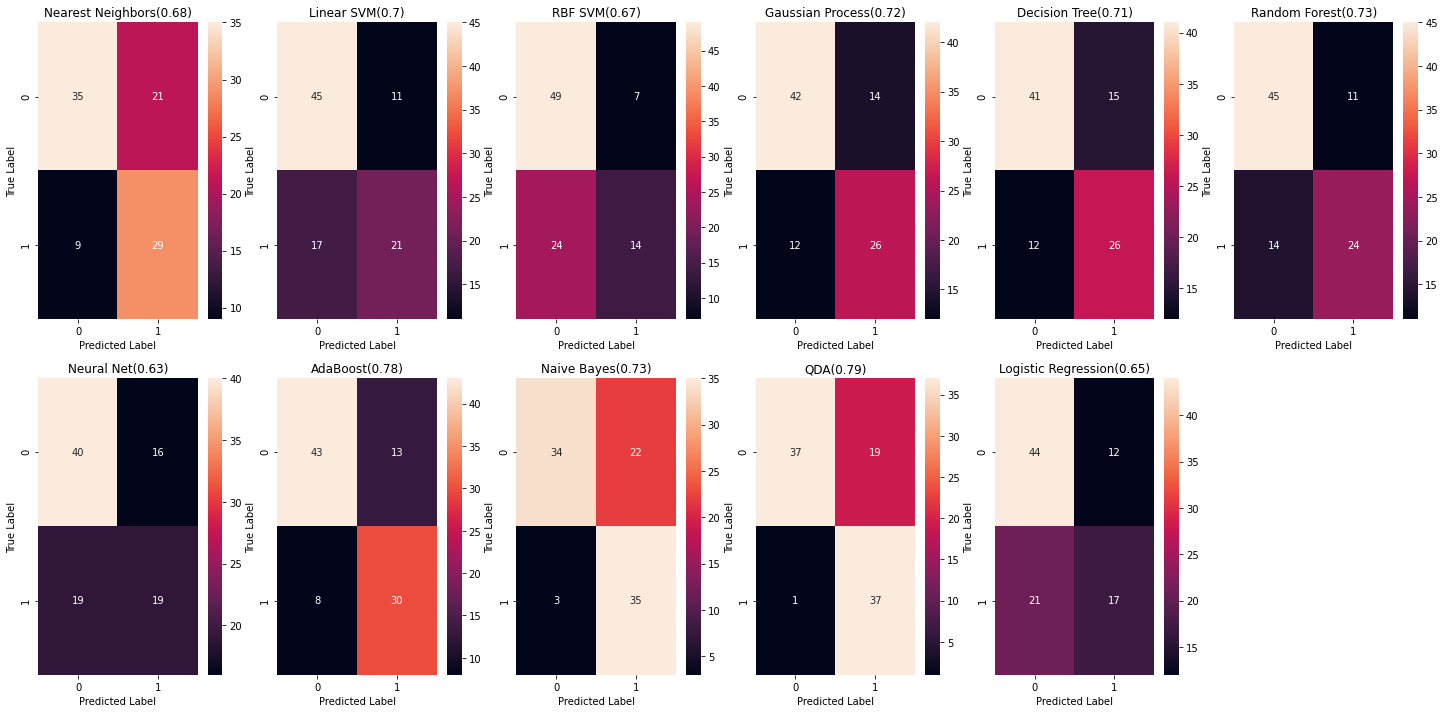

In [18]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import StratifiedKFold

plt.rcParams["figure.figsize"] = [25, 12]

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA", "Logistic Regression"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(solver='liblinear')]

X = np.array(df[['userBPM','userConsistency','songBPM','ratioBPM','ratioBPMabs']])
y = np.array(df[['onRhythm']])

skf = StratifiedKFold(n_splits=3, shuffle=True)
skf.get_n_splits(X, y)
i = 1
for name, clf in zip(names, classifiers):
  sum = 0
  cmSum = [[0,0],[0,0]]
  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]
      # train_data = df.iloc[train]
      # test_data = df.iloc[test]
      clf.fit(X_train, y_train.ravel())
      score = clf.score(X_test, y_test)
      sum += score
      pred = clf.predict(X_test)
      cm=confusion_matrix(y_test,pred)
      cmSum += cm
  average = sum/3
  #print(name)
  #print(average)
  #print(cmSum)
  axI = plt.subplot(2, 6, i)
  sns.heatmap(cmSum,annot=True, ax=axI)
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.title(name + "(" + str(round(average,2)) + ")")
  i += 1

## Plot decision tree

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


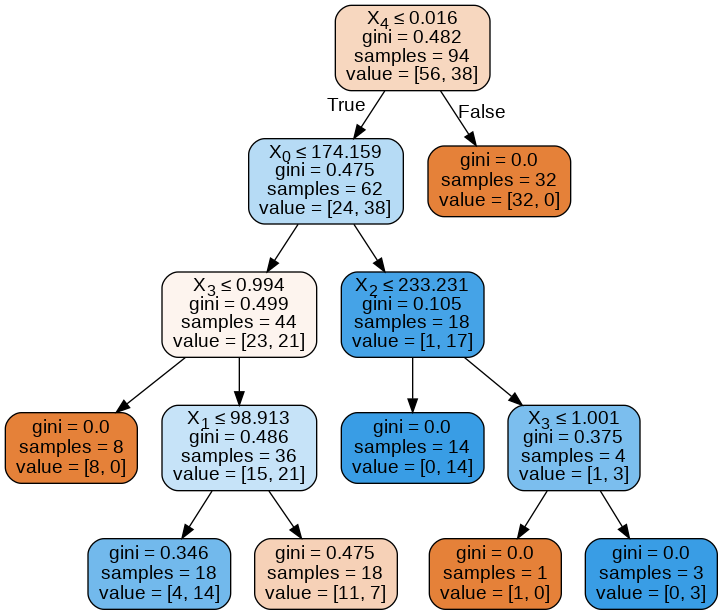

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dtree=DecisionTreeClassifier(max_depth=4)
dtree.fit(X,y.ravel())

dot_data = StringIO()

export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
